# Ch. 6 Deep learning for text and sequences

This section explore deep learning models that can process text, timeseries, and sequence data in general. The two fundamental deep learning algorithms for sequence processing are ***recurrent neural networks*** and ***1D convenets***, which is a one dimensional version of 2D convnets. Applications of these algorithms include:
 - Document classification and timeseries classification, such as identifying the topic of an article or author of a book.
 - Timeseries comparisons, such as estimating how closely related two documents or two stock tickers are.
 - Sequence-to-sequence learning, such as decoding an English sentence into French.
 - Sentiment analysis, such as classifying the sentiment of tweets or movie reviews as positive or negative.
 - Timeseries forecasting, such as predicting the future weather at a certain location, given recent weather data.
 
## 6.1 Working with text data
Text can be unstood as either a sequence of characters or a sequence of words, but working with words is most common. Deep learning for natural language processing is pattern recognition applied to words, sentences, and paragraphs, in much the same way that computer vision is pattern recognition applied to pixels.

Deep learning models don't take raw text as input; they only work with numeric tensors. ***Vectorizing*** text is the process of transforming text into numeric tensors, and it can be done in multiple ways:
 - Segment text into words, and transform each word into a vector.
 - Segment text into characters, and transform each n-gram into a vector.
 - Extract n-grams of words or characters, and transform each n-gram into a vector. *N-grams* are overlapping groups of multiple consecutive words or characters.
 
The different units we can break text into are called ***tokens***, and breaking text into tokens is called ***tokenization***. There are two major ways to associate a vector with a token: *one-hot encoding* of tokens, and *token embedding*.

![text token vector](images/6_1_0_text.jpg)

**UNDERSTANDING N-GRAMS AND BAG-OF-WORDS**
Word n-grams are groups of N (or fewer) consecutive words that you can extract from a sentence. The same concept may also be applied to letters.

Here is a simple example. Consider the sentence *"The cat sat on the mat."* It may be decomposed into the following set of 2-grams:

`{"The","The cat","cat","cat sat","sat","sat on","on","on the","the","the mat","mat"}`

It may also be decomposed into a set of 3-grams:

`{"The","The cat","cat","cat sat","The cat sat","sat","sat on","on","cat sat on",
  "on the","the","sat on the","the mat","mat","on the mat"}`
  
The above sets are called a *bag-of-2-grams* or *bag-of-3-grams*, respectively. The term bag refers to the fact that we are dealing with a set of tokens rather than a list or sequence: the tokens have no specific order. This family of tokenization methods is called *bag-of-words*.

Because bag-of-words isn't an order-preserving tokenization method, it tends to be used in shallow language-processing models rather than in deep learning models. Extracting n-grams is a form of feature engineering, and deep learning does away with this kind of rigid, brittle approach, replacing it with hierarchical feature learning. 1D convnets and RNNs are capable of learning representations for groups of words and characters without being explicitly told about the existence of such groups, by looking at continuous word or character sequences. 

### 6.1.1 One-hot encoding of words and characters
One-hot encoding is the most common, most basic way to turn a token into a vector.

Let's look at an example of one-hot encoding with words:

In [1]:
import numpy as np

# initial data. One entry per sample
samples = ['The cat sat on the mat.', 'The dog at my homework.']

# Build an index of all tokens in data
token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1
            
# Vectorizes the samples. Only consider first 10 words            
max_length = 10

# Store results
results = np.zeros(shape=(len(samples), max_length, max(token_index.values()) + 1))

for i, samples in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

And an example of one-hot encoding with characters:

In [3]:
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable # all printable ASCII characters
token_index = dict(zip(range(1, len(characters) + 1), characters))

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



In [6]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable # all printable ASCII characters
token_index = dict(zip(range(1, len(characters) + 1), characters))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.keys()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1.

Now that we did it the hard way, let's observe how Keras has built-in utilities for doing one-hot encoding of text at the word level or character level, starting with raw text data. These utilities are useful because they strip special characters from strings and only take the *N* most common words into account.

In [13]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# create a tokenizer to take only most 1000 common words
tokenizer = Tokenizer(num_words=1000)

# build the word index
tokenizer.fit_on_texts(samples)

# turn strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# recover word index
word_index = tokenizer.word_index
print "Found %s unique tokens." % len(word_index)

Found 9 unique tokens.


In [14]:
word_index

{'ate': 7,
 'cat': 2,
 'dog': 6,
 'homework': 9,
 'mat': 5,
 'my': 8,
 'on': 4,
 'sat': 3,
 'the': 1}

**HASHING TRICK**

A variant of one-hot encoding is the *one-hot hashing trick*, which you can use when the number of unique tokens in your vocabulary is too large to handle explicitly. Instead of explicitly assigning an index to each word and keeping a reference of these indices in a dictionary, you can hash words into vectors of fixed size. The advantage of this method is that it does away with maintaining an explicit word index, which saves memory and allows online encoding of the data. The one drawback is that this method is susceptible to *hash collisions*: two different words may end up with the same hash.

Let's see a code example:

In [16]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Stores the words as vectors of size 1000
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

### 6.1.2 Using word embeddings
Another popular and powerful way to associate a vector with a word is the use of dense ***word vectors***, aka ***word embeddings***. While vectors obtained through one-hot encoding are binary, sparse, and very high-dimensional, word embeddings are low-dimensional floating-point vectors. Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. It's common to see word embeddings that are 512-dimensional, or 1,024-dimensional when dealing with very large vocabularies, but one-hot encoding words generally lead to vectors that are 20,000-dimensional or greater. Word embeddings pack more information into far fewer dimensions.

![word embeddings](images/6_1_2_embeddings.jpg)

There are two ways to obtain word embeddings:
 - Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.
 - Load word embeddings into your model that were precomputed using a different machine learning task than the one you're trying to solve. These are called *pretrained word embeddings*.
 
Let's dive deeper into both:

**LEARNING WORD EMBEDDINGS WITH THE EMBEDDING LAYER**

The simplest way to associate a dense vector with a word is to choose the vector at random. The problem with this approach is that the resulting embedding space has no structure: for instance, the words *accurate* and *exact* may end up with completely different embeddings, even though they're interchangeable in most sentences. It's difficult for a deep neural network to make sense of such a noisy, unstructured embedding space.

Word embeddings are meant to map human language into a geometric space. In a reasonable embedding space, you would expect synonyms to be embedded into similar word vectors, and words meaning different things are embedded at points far away from each other, whereas related words are closer. Let's look at an example.

![word embedding example](images/6_1_2_space.jpg)

In the image about, four words are embedded on a 2D plane: *cat, dog, wolf,* and *tiger*. With the vector representations we chose here, some semantic relationships between these words can be encoded as geometric transformations. For instance, the same vector allows us to go from *cat* to *tiger* and from *dog* to *wolf*: this vector could be interpreted as the "from pet to wild animal" vector. Another vector could allow us to go from *dog* to *cat* and from *wolf* to *tiger*, which could be interpreted as a "from canine to feline" vector.

In real-world word-embedding spaces, common examples of meaningful geometric transformations are "gender" vectors and "plural" vectors. For instance, by adding a "femal" vector to the vector "king," we obtain the vector "queen". By adding a "plural" vector, we obtain "kings". 

What makes a good word-embedding space depends heavily on your task: the perfect word-embedding space for an English-language movie-review sentiment analysis model may look different from the perfect embedding space for an English-language legal-document-classification model, because the importance of certain semantic relationships varies from task to task. Thus, it's reasonable to learn a new embedding space with every new task. Fortunately, backpropagation makes this easy, and Keras makes it even easier. It's about learning the weights of an **`Embedding`** layer.

In [17]:
from keras.layers import Embedding

# Embedding layer takes two arguments: number of possible tokens & dimen. of embeddings
embedding_layer = Embedding(1000, 64)

The **`Embedding`** layer is best understood as a dictionary that maps interger indices (words) to dense vectors. It takes integers as its input, looks up these integers in an internal dictionary, and then returns the associated vectors. 

The **`Embedding`** layer takes a 2D tensor of integers as an input, of shape (`samples, sequence_length`), where each entry is a sequence of integers. All sequences in a batch must have the same length, so sequences that are shorter than others should be padded with zeros, and longer sequences should be truncated.

This layer returns a 3D floating-point tensor of shape (`samples, sequence_length, embedding_dimensionality`). This tensor can be processed by an RNN layer or a 1D convolution layer.

Let's apply this idea to the IMDB movie-review sentiment-prediction task. We will quickly prepare the data by restricting the movie reviews to the top 10,000 most common words and cut off the reviews after only 20 words. The network will learn 8-dimensional embeddings for each of the 10,000 words, turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` layer on top for classification.

**LOADING IMDB DATA FOR USE WITH EMBEDDING LAYER**

In [18]:
from keras.datasets import imdb
from keras import preprocessing

# number of words to consider as features
max_features = 10000

# cut off text after this many words
maxlen = 20

# load data as list of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# turn list of integers into a 2D integer tensor of shape (samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

**USING EMBEDING LAYER AND CLASSIFIER ON IMDB DATA**

In [20]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()

# specify max input length to embedding layer so we can later flatten embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

# Add classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s - loss: 0.6685 - acc: 0.6234 - val_loss: 0.6174 - val_acc: 0.6938
Epoch 2/10
20000/20000 [==============================] - 2s - loss: 0.5389 - acc: 0.7539 - val_loss: 0.5247 - val_acc: 0.7316
Epoch 3/10
20000/20000 [==============================] - 2s - loss: 0.4580 - acc: 0.7928 - val_loss: 0.5014 - val_acc: 0.7478
Epoch 4/10
20000/20000 [==============================] - 2s - loss: 0.4186 - acc: 0.8104 - val_loss: 0.4951 - val_acc: 0.7518
Epoch 5/10
20000/20000 [==============================] - 2s - loss: 0.3915 - acc: 0.8250 - val_loss: 0.4958 - val_acc: 0.7536
Epoch 6/10
20000/20000 [==============================] - 2s - loss: 0.3697 - acc: 0.8375 - val_loss: 0.5003 - val_acc: 0.7512
Epoch 7/10
20000/20000 [==============================] - 2s - loss: 0.3502 - acc: 0.8503 - val_loss: 0.5062 - val_acc: 0.7502
Epoch 8/10
20000/20000 [==============================] - 2s -

We get a validation accuracy of ~75%, which isn't bad considering we are only looking at the first 20 words of each review. By merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and sentence structure ("this movie is the bomb" vs. "this movie was a bomb"). It's better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take each sequence as a whole into account.

**USING PRETRAINED WORD EMBEDDINGS**
Sometimes, you have so little training data available that you can't use your data alone to learn an appropriate task-specific embedding of your vocabulary. What do you do then?

Instead of learning word embeddings jointly with the problem you want to solve, you can load embedding vectors from precomputed embedding space that you know if highly structures and exhibits useful properties that capture generic aspects of language structure. 

Such word embeddings are generally computed using word-occurrence statistics, using a variety of techniques, some involving neural networks, others not. There are various precomputed databases of word embeddings that you can download and use in a Keras `Embedding` layer. Word2vec is one of them. Another popular one is called Global Vectors for Word Representation (GLoVE).

### 6.1.3 Putting it all together: from raw text to word embeddings
We'll use a model similar to the one above: embedding sentences in sequences of vectors, flattening them, and training a `Dense` layer on top. But we'll do so using pretrained word embeddings. And instead of using the pretokenized IMDB data packaged in Keras, we will start from scratch using raw text data.

**DOWNLOADING THE IMDB DATA AS RAW TEXT**

In [22]:
import os

imdb_dir = '/Volumes/RobStorage/Desktop/Python_Practice/DL_with_Python/data/IMDB/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

**TOKENIZING THE DATA**

Let's vectorize the text and prepare a training and validation split. Because pretrained word embeddings are meant to be particularly useful on problems where little training data is available, we'll restrict the training data to the first 200 samples. Our model will learn to classify movie reviews are looking at **just 200 samples**!

In [23]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Cut off reviews after 100 words
maxlen = 100

# Trains on 200 samples
training_samples = 200

# Validates on 10,000 samples
validation_samples = 10000

# Consider only top 10,000 words in dataset
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print "Found %s unique tokens." % len(word_index)

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print "Shape of data tensor:", data.shape
print "Shape of label tensor:", labels.shape

# Split data into a training & validation set
# Shuffle data first because samples are all negative first
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88584 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


**DOWNLOAD GLoVE WORD EMBEDDINGS**

The GLoVE word embeddings contain 100-dimensional embedding vectors for 400,000 words.

In [24]:
glove_dir = '/Volumes/RobStorage/Desktop/Python_Practice/DL_with_Python/data/IMDB/glove.6B'

**PREPROCESSING THE EMBEDDINGS**

Let's parse the unzipped file to build an index that maps words (as strings) to their vector representation (as number vectors).

In [25]:
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print "Found %s word vectors." % len(embeddings_index)

Found 400000 word vectors.


Now we will build an embedding matrix that we can load into an `Embedding` layer. It must be a matrix of shape (`max_words, embedding_dim`). Note that index 0 is a placeholder and isn't supposed to stand for any word or token.

**PREPARING THE GLoVE WORD-EMBEDDINGS MATRIX**

In [26]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # words not found in embedding = 0

**DEFINE A MODEL**
We will use the same model architecture as before.

In [27]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


**LOADING THE GLoVE EMBEDDINGS IN THE MODEL**
The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry $i$ is the word vector meant to be associated with index $i$. Let's load the GLoVE matrix we prepared into the `Embedding` layer.

In [28]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

We will also freeze the `Embedding` layer (trainable = False). When parts of a model are pretrained (like our `Embedding` layer) and parts are randomly initialized (like our classifier), the pretrained parts shouldn't be updated during training, to avoid forgetting what they already know.

**TRAINING AND EVALUATING THE MODEL**

In [29]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s - loss: 2.0330 - acc: 0.5150 - val_loss: 0.7080 - val_acc: 0.5280
Epoch 2/10
200/200 [==============================] - 1s - loss: 0.5197 - acc: 0.7500 - val_loss: 0.9988 - val_acc: 0.5016
Epoch 3/10
200/200 [==============================] - 1s - loss: 0.4037 - acc: 0.8550 - val_loss: 0.7129 - val_acc: 0.5466
Epoch 4/10
200/200 [==============================] - 1s - loss: 0.3290 - acc: 0.8650 - val_loss: 1.0471 - val_acc: 0.5001
Epoch 5/10
200/200 [==============================] - 1s - loss: 0.2387 - acc: 0.9400 - val_loss: 0.7075 - val_acc: 0.5710
Epoch 6/10
200/200 [==============================] - 0s - loss: 0.1135 - acc: 1.0000 - val_loss: 1.1586 - val_acc: 0.5030
Epoch 7/10
200/200 [==============================] - 1s - loss: 0.2337 - acc: 0.9000 - val_loss: 0.7440 - val_acc: 0.5673
Epoch 8/10
200/200 [==============================] - 1s - loss: 0.0554 - acc: 1.0000 - val

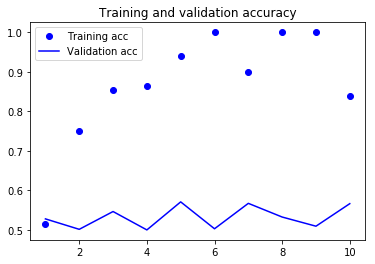

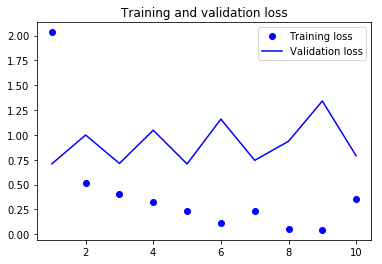

In [30]:
# plot model's performance over time
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model begins overfitting almost from the start, which makes sense because we only used 200 training samples. The validation accuracy seems to reach high 50%, which isn't ideal. Because we have so few training samples, performance is heavily dependent on exactly which 200 samples we choose.

We can also try training the same model without loading the pretrained word embeddings and without freezing the embedding layer. Doing this, we will learn a task-specific embedding of the input tokens, which is generally more powerful than pretrained word embeddings when lots of data is available. Let's try this method:

**TRAINING SAME MODEL WITHOUT PRETRAINED WORD EMBEDDINGS**

In [31]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s - loss: 0.6898 - acc: 0.4800 - val_loss: 0.6927 - val_acc: 0.5232
Epoch 2/10
200/200 [==============================] - 1s - loss: 0.5005 - acc: 0.9850 - val_l

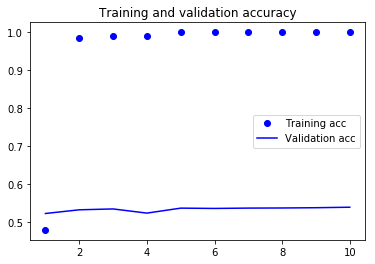

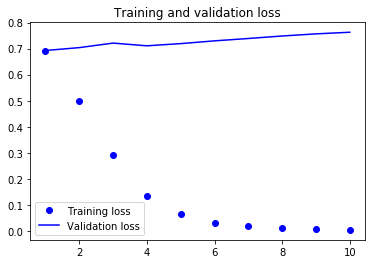

In [32]:
# plot model's performance over time
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The validation accuracy stalls in the low 50s. In this case, pretrained word embeddings outperform jointly learned embeddings. If we increase the number of training samples, this will quickly stop being the case.

Finally, let's evaluate the model on the test data. First, we need to tokenize the test data.

In [33]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [34]:
# load and evaluate the first model
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

24576/25000 [============================>.] - ETA: 0s

[0.8004352753829956, 0.56004]

Yikes! We got a terrible test accuracy of **56%**. Working with just a handfull of training samples is difficult. We will consider this a lesson learned, and will attempt improved strategies in the next section.

At this point, we are able to do the following:
 - **Turn raw text into something a neural network can process**
 - **Use the `Embedding` layer in a Keras model to learn task-specific token embeddings**
 - **Use pretrained word embeddings to get an extra boost on small NLP problems**